(blackbox_external_likelihood_numpy)=
# Using a "black box" likelihood function

:::{post} Dec 16, 2021
:tags: PyTensor 
:category: advanced, how-to
:author: Matt Pitkin, Jørgen Midtbø, Oriol Abril, Ricardo Vieira
:::

:::{note}
There is a {ref}`related example <wrapping_jax_function>` that discusses how to use a likelihood implemented in JAX
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.3


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Introduction
PyMC is a great tool for doing Bayesian inference and parameter estimation. It has many {doc}`in-built probability distributions <pymc:api/distributions>` that you can use to set up priors and likelihood functions for your particular model. You can even create your own {class}`Custom Distribution <pymc.CustomDist>` with a custom logp defined by PyTensor operations or automatically inferred from the generative graph.

Despite all these "batteries included", you may still find yourself dealing with a model function or probability distribution that relies on complex external code that you cannot avoid but to use. This code is unlikely to work with the kind of abstract PyTensor variables that PyMC uses: {ref}`pymc:pymc_pytensor`.

```python
import pymc as pm
from external_module import my_external_func  # your external function!

# set up your model
with pm.Model():
    # your external function takes two parameters, a and b, with Uniform priors
    a = pm.Uniform('a', lower=0., upper=1.)
    b = pm.Uniform('b', lower=0., upper=1.)
    
    m = my_external_func(a, b)  # <--- this is not going to work!
```

Another issue is that if you want to be able to use the gradient-based step samplers like {term}`NUTS` and {term}`Hamiltonian Monte Carlo`, then your model/likelihood needs a gradient to be defined. If you have a model that is defined as a set of PyTensor operators then this is no problem - internally it will be able to do automatic differentiation - but if your model is essentially a "black box" then you won't necessarily know what the gradients are.

Defining a model/likelihood that PyMC can use and that calls your "black box" function is possible, but it relies on creating a custom PyTensor Op. This is, hopefully, a clear description of how to do this, including one way of writing a gradient function that could be generally applicable.

In the examples below, we create a very simple linear model and log-likelihood function in numpy.

In [3]:
def my_model(m, c, x):
    return m * x + c


def my_loglike(m, c, sigma, x, data):
    # We fail explicitly if inputs are not numerical types for the sake of this tutorial
    # As defined, my_loglike would actually work fine with PyTensor variables!
    for param in (m, c, sigma, x, data):
        if not isinstance(param, (float, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}")
    model = my_model(m, c, x)
    return -0.5 * ((data - model) / sigma) ** 2 - np.log(np.sqrt(2 * np.pi)) - np.log(sigma)

Now, as things are, if we wanted to sample from this log-likelihood function, using certain prior distributions for the model parameters (gradient and y-intercept) using PyMC, we might try something like this (using a {class}`pymc.CustomDist` or {class}`pymc.Potential`):

```python
import pymc as pm

# create/read in our "data" (I'll show this in the real example below)
x = ...
sigma = ...
data = ...

with pm.Model():
    # set priors on model gradient and y-intercept
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create custom distribution 
    pm.CustomDist('likelihood', m, c, sigma, x, observed=data, logp=my_loglike)
    
    # sample from the distribution
    trace = pm.sample(1000)
```

But, this will likely give an error when the black-box function does not accept PyTensor tensor objects as inputs.

So, what we actually need to do is create a {ref}`PyTensor Op <pytensor:creating_an_op>`. This will be a new class that wraps our log-likelihood function while obeying the PyTensor API contract. We will do this below, initially without defining a {func}`grad` for the Op.

:::{tip}
Depending on your application you may only need to wrap a custom log-likelihood or a subset of the whole model (such as a function that computes an infinite series summation using an advanced library like mpmath), which can then be chained with other PyMC distributions and PyTensor operations to define your whole model. There is a trade-off here, usually the more you leave out of a black-box the more you may benefit from PyTensor rewrites and optimizations. We suggest you always try to define the whole model in PyMC and PyTensor, and only use black-boxes where strictly necessary.
:::

## PyTensor Op without gradients

### Op definition

In [4]:
# define a pytensor Op for our likelihood function


class LogLike(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Convert inputs to tensor variables
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        # Define output type, in our case a vector of likelihoods
        # with the same dimensions and same data type as data
        # If data must always be a vector, we could have hard-coded
        # outputs = [pt.vector()]
        outputs = [data.type()]

        # Apply is an object that combines inputs, outputs and an Op (self)
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # This is the method that compute numerical output
        # given numerical inputs. Everything here is numpy arrays
        m, c, sigma, x, data = inputs  # this will contain my variables

        # call our numpy log-likelihood function
        loglike_eval = my_loglike(m, c, sigma, x, data)

        # Save the result in the outputs list provided by PyTensor
        # There is one list per output, each containing another list
        # pre-populated with a `None` where the result should be saved.
        outputs[0][0] = np.asarray(loglike_eval)

In [5]:
# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model(mtrue, ctrue, x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

Now that we have some data we initialize the actual Op and try it out.

In [6]:
# create our Op
loglike_op = LogLike()

test_out = loglike_op(mtrue, ctrue, sigma, x, data)

`pytensor.dprint` prints a textual representation of a PyTensor graph.
We can see our variable is the output of the `LogLike` Op and has a type of `pt.vector(float64, shape=(10,))`.
We can also see the five constant inputs and their types.

In [7]:
pytensor.dprint(test_out, print_type=True)

LogLike [id A] <Vector(float64, shape=(10,))>
 ├─ 0.4 [id B] <Scalar(float64, shape=())>
 ├─ 3.0 [id C] <Scalar(float32, shape=())>
 ├─ 1.0 [id D] <Scalar(float32, shape=())>
 ├─ [0. 1. 2. ... 7. 8. 9.] [id E] <Vector(float64, shape=(10,))>
 └─ [2.3876939 ... .56436476] [id F] <Vector(float64, shape=(10,))>


Because all inputs are constant, we can use the handy `eval` method to evaluate the output

In [8]:
test_out.eval()

array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
       -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])

We can confirm this returns what we expect

In [9]:
my_loglike(mtrue, ctrue, sigma, x, data)

array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
       -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])

### Model definition

Now, let's use this Op to repeat the example shown above. To do this let's create some data containing a straight line with additive Gaussian noise (with a mean of zero and a standard deviation of `sigma`). For simplicity we set {class}`~pymc.Uniform` prior distributions on the gradient and y-intercept. As we've not set the `grad()` method of the Op PyMC will not be able to use the gradient-based samplers, so will fall back to using the {class}`pymc.Slice` sampler.

In [10]:
def custom_dist_loglike(data, m, c, sigma, x):
    # data, or observed is always passed as the first input of CustomDist
    return loglike_op(m, c, sigma, x, data)


# use PyMC to sampler from log-likelihood
with pm.Model() as no_grad_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0, initval=mtrue)
    c = pm.Uniform("c", lower=-10.0, upper=10.0, initval=ctrue)

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )

Before we even sample, we can check if the model logp is correct (and no errors are raised). 

We need a point to evaluate the logp, which we can get with `initial_point` method. 
This will be the transformed initvals we defined in the model.

In [11]:
ip = no_grad_model.initial_point()
ip

{'m_interval__': array(0.08004271), 'c_interval__': array(0.61903921)}

We sholud get exactly the same values as when we tested manually!

In [12]:
no_grad_model.compile_logp(vars=[likelihood], sum=False)(ip)

[array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
        -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])]

We can also double-check that PyMC will error out if we try to extract the model gradients with respect to the logp (which we call `dlogp`)

In [13]:
try:
    no_grad_model.compile_dlogp()
except Exception as exc:
    print(type(exc))

<class 'NotImplementedError'>


Finally, let's sample!

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [m]
>Slice: [c]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


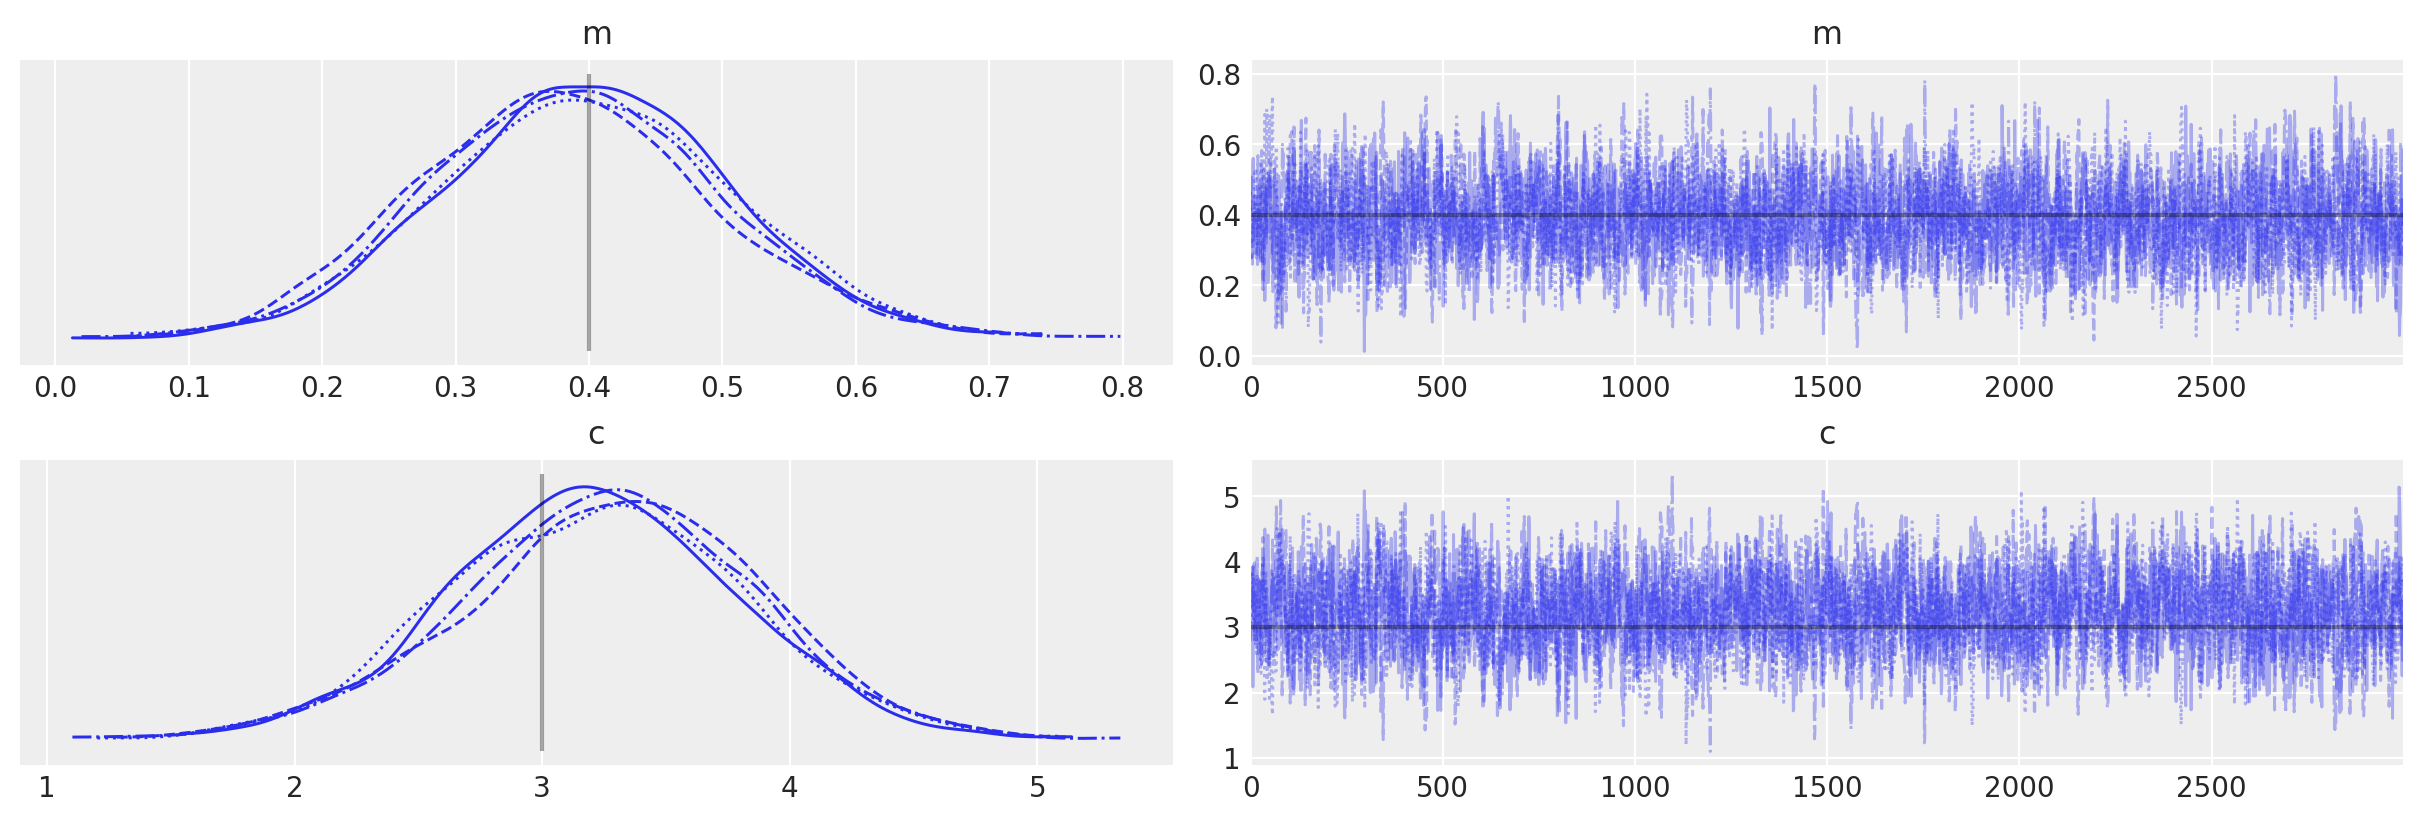

In [14]:
with no_grad_model:
    # Use custom number of draws to replace the HMC based defaults
    idata_no_grad = pm.sample(3000, tune=1000)

# plot the traces
az.plot_trace(idata_no_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

## PyTensor Op with gradients

What if we wanted to use NUTS or HMC? If we knew the analytical derivatives of the model/likelihood function then we could add a {func}`grad` to the Op using existing PyTensor operations.

But, what if we don't know the analytical form. If our model/likelihood, is implemented in a framework that provides automatic differentiation (just like PyTensor does), it's possible to reuse their functionality. This {ref}`related example <wrapping_jax_function>` shows how to do this when working with JAX functions.

If our model/likelihood truly is a "black box" then we can try to use approximation methods like [finite difference](https://en.wikipedia.org/wiki/Finite_difference) to find the gradients. We illustrate this approach with the handy SciPy {func}`~scipy.optimize.approx_fprime` function to achieve this.

:::{caution}
Finite differences are rarely recommended as a way to compute gradients. They can be too slow or unstable for practical uses. We suggest you use them only as a last resort. 
:::

### Op definition

In [15]:
def finite_differences_loglike(m, c, sigma, x, data, eps=1e-7):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using scipy approx_fprime function.

    Parameters
    ----------
    m, c: array_like
        The parameters of the function for which we wish to define partial derivatives
    x, data, sigma:
        Observed variables as we have been using so far


    Returns
    -------
    grad_wrt_m: array_like
        Partial derivative wrt to the m parameter
    grad_wrt_c: array_like
        Partial derivative wrt to the c parameter
    """

    def inner_func(mc, sigma, x, data):
        return my_loglike(*mc, sigma, x, data)

    grad_wrt_mc = approx_fprime([m, c], inner_func, [eps, eps], sigma, x, data)

    return grad_wrt_mc[:, 0], grad_wrt_mc[:, 1]

In [16]:
finite_differences_loglike(mtrue, ctrue, sigma, x, data)

(array([ 0.        , -0.11778783,  1.84843447, -0.06637035,  5.06387346,
         4.2587707 ,  0.02964459, -3.2668551 ,  9.89728189, -9.32072126]),
 array([-0.61230613, -0.11778783,  0.92421729, -0.02212335,  1.26596852,
         0.85175434,  0.00494102, -0.46669328,  1.23716059, -1.0356353 ]))

So, now we can just redefine our Op with a `grad()` method, right?

It's not quite so simple! The `grad()` method itself requires that its inputs are PyTensor tensor variables, whereas our `gradients` function above, like our `my_loglike` function, wants a list of floating point values. So, we need to define another Op that calculates the gradients. Below, I define a new version of the `LogLike` Op, called `LogLikeWithGrad` this time, that has a `grad()` method. This is followed by anothor Op called `LogLikeGrad` that, when called with a vector of PyTensor tensor variables, returns another vector of values that are the gradients (i.e., the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)) of our log-likelihood function at those values. Note that the `grad()` method itself does not return the gradients directly, but instead returns the [Jacobian-vector product](https://en.wikipedia.org/wiki/Pushforward_(differential)).

In [17]:
# define a pytensor Op for our likelihood function


class LogLikeWithGrad(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Same as before
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        outputs = [data.type()]
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # Same as before
        m, c, sigma, x, data = inputs  # this will contain my variables
        loglike_eval = my_loglike(m, c, sigma, x, data)
        outputs[0][0] = np.asarray(loglike_eval)

    def grad(
        self, inputs: list[pt.TensorVariable], g: list[pt.TensorVariable]
    ) -> list[pt.TensorVariable]:
        # NEW!
        # the method that calculates the gradients - it actually returns the vector-Jacobian product
        m, c, sigma, x, data = inputs

        # Our gradient expression assumes these are scalar parameters
        if m.type.ndim != 0 or c.type.ndim != 0:
            raise NotImplementedError("Gradient only implemented for scalar m and c")

        grad_wrt_m, grad_wrt_c = loglikegrad_op(m, c, sigma, x, data)

        # out_grad is a tensor of gradients of the Op outputs wrt to the function cost
        [out_grad] = g
        return [
            pt.sum(out_grad * grad_wrt_m),
            pt.sum(out_grad * grad_wrt_c),
            # We did not implement gradients wrt to the last 3 inputs
            # This won't be a problem for sampling, as those are constants in our model
            pytensor.gradient.grad_not_implemented(self, 2, sigma),
            pytensor.gradient.grad_not_implemented(self, 3, x),
            pytensor.gradient.grad_not_implemented(self, 4, data),
        ]


class LogLikeGrad(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        # There are two outputs with the same type as data,
        # for the partial derivatives wrt to m, c
        outputs = [data.type(), data.type()]

        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        m, c, sigma, x, data = inputs

        # calculate gradients
        grad_wrt_m, grad_wrt_c = finite_differences_loglike(m, c, sigma, x, data)

        outputs[0][0] = grad_wrt_m
        outputs[1][0] = grad_wrt_c


# Initalize the Ops
loglikewithgrad_op = LogLikeWithGrad()
loglikegrad_op = LogLikeGrad()

We should test the gradient is working before we jump back to the model.

Instead of evaluating the loglikegrad_op directly, we will use the same PyTensor grad machinery that PyMC will ultimately use, to make sure there are no surprises.

For this we will provide symbolic inputs for `m` and `c` (which in the PyMC model will be RandomVariables).

In [18]:
m = pt.scalar("m")
c = pt.scalar("c")
out = loglikewithgrad_op(m, c, sigma, x, data)

Since our loglike Op is also new, let's make sure it's output is still correct. We can still use `eval` but because we have two non-constant inputs we need to provide values for those.

In [19]:
eval_out = out.eval({m: mtrue, c: ctrue})
print(eval_out)
assert np.allclose(eval_out, my_loglike(mtrue, ctrue, sigma, x, data))

[-1.1063979  -0.92587551 -1.34602737 -0.91918325 -1.72027674 -1.2816813
 -0.91895074 -1.02783982 -1.68422175 -1.45520871]


If you are interested you can see how the gradient computational graph looks like, but it's a bit messy. 

You can see that both `LogLikeWithGrad` and `LogLikeGrad` show up as expected

In [20]:
grad_wrt_m, grad_wrt_c = pytensor.grad(out.sum(), wrt=[m, c])
pytensor.dprint([grad_wrt_m], print_type=True)

Sum{axes=None} [id A] <Scalar(float64, shape=())>
 └─ Mul [id B] <Vector(float64, shape=(10,))>
    ├─ Second [id C] <Vector(float64, shape=(10,))>
    │  ├─ LogLikeWithGrad [id D] <Vector(float64, shape=(10,))>
    │  │  ├─ m [id E] <Scalar(float64, shape=())>
    │  │  ├─ c [id F] <Scalar(float64, shape=())>
    │  │  ├─ 1.0 [id G] <Scalar(float32, shape=())>
    │  │  ├─ [0. 1. 2. ... 7. 8. 9.] [id H] <Vector(float64, shape=(10,))>
    │  │  └─ [2.3876939 ... .56436476] [id I] <Vector(float64, shape=(10,))>
    │  └─ ExpandDims{axis=0} [id J] <Vector(float64, shape=(1,))>
    │     └─ Second [id K] <Scalar(float64, shape=())>
    │        ├─ Sum{axes=None} [id L] <Scalar(float64, shape=())>
    │        │  └─ LogLikeWithGrad [id D] <Vector(float64, shape=(10,))>
    │        │     └─ ···
    │        └─ 1.0 [id M] <Scalar(float64, shape=())>
    └─ LogLikeGrad.0 [id N] <Vector(float64, shape=(10,))>
       ├─ m [id E] <Scalar(float64, shape=())>
       ├─ c [id F] <Scalar(float64, s

The best way to confirm we implemented the gradient correctly is to use PyTensor's `verify_grad` utility

In [21]:
def test_fn(m, c):
    return loglikewithgrad_op(m, c, sigma, x, data)


# This raises an error if the gradient output is not within a given tolerance
pytensor.gradient.verify_grad(test_fn, pt=[mtrue, ctrue], rng=np.random.default_rng(123))

### Model definition

Now, let's re-run PyMC with our new "grad"-ed Op. This time it will be able to automatically use NUTS.

In [22]:
def custom_dist_loglike(data, m, c, sigma, x):
    # data, or observed is always passed as the first input of CustomDist
    return loglikewithgrad_op(m, c, sigma, x, data)


# use PyMC to sampler from log-likelihood
with pm.Model() as grad_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )

The loglikelihood should not have changed.

In [23]:
grad_model.compile_logp(vars=[likelihood], sum=False)(ip)

[array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
        -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])]

But this time we should be able to evaluate the dlogp (wrt to m and c) as well

In [24]:
grad_model.compile_dlogp()(ip)

array([41.52474277,  8.93420609])

And, accordingly, NUTS will now be selected by default

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


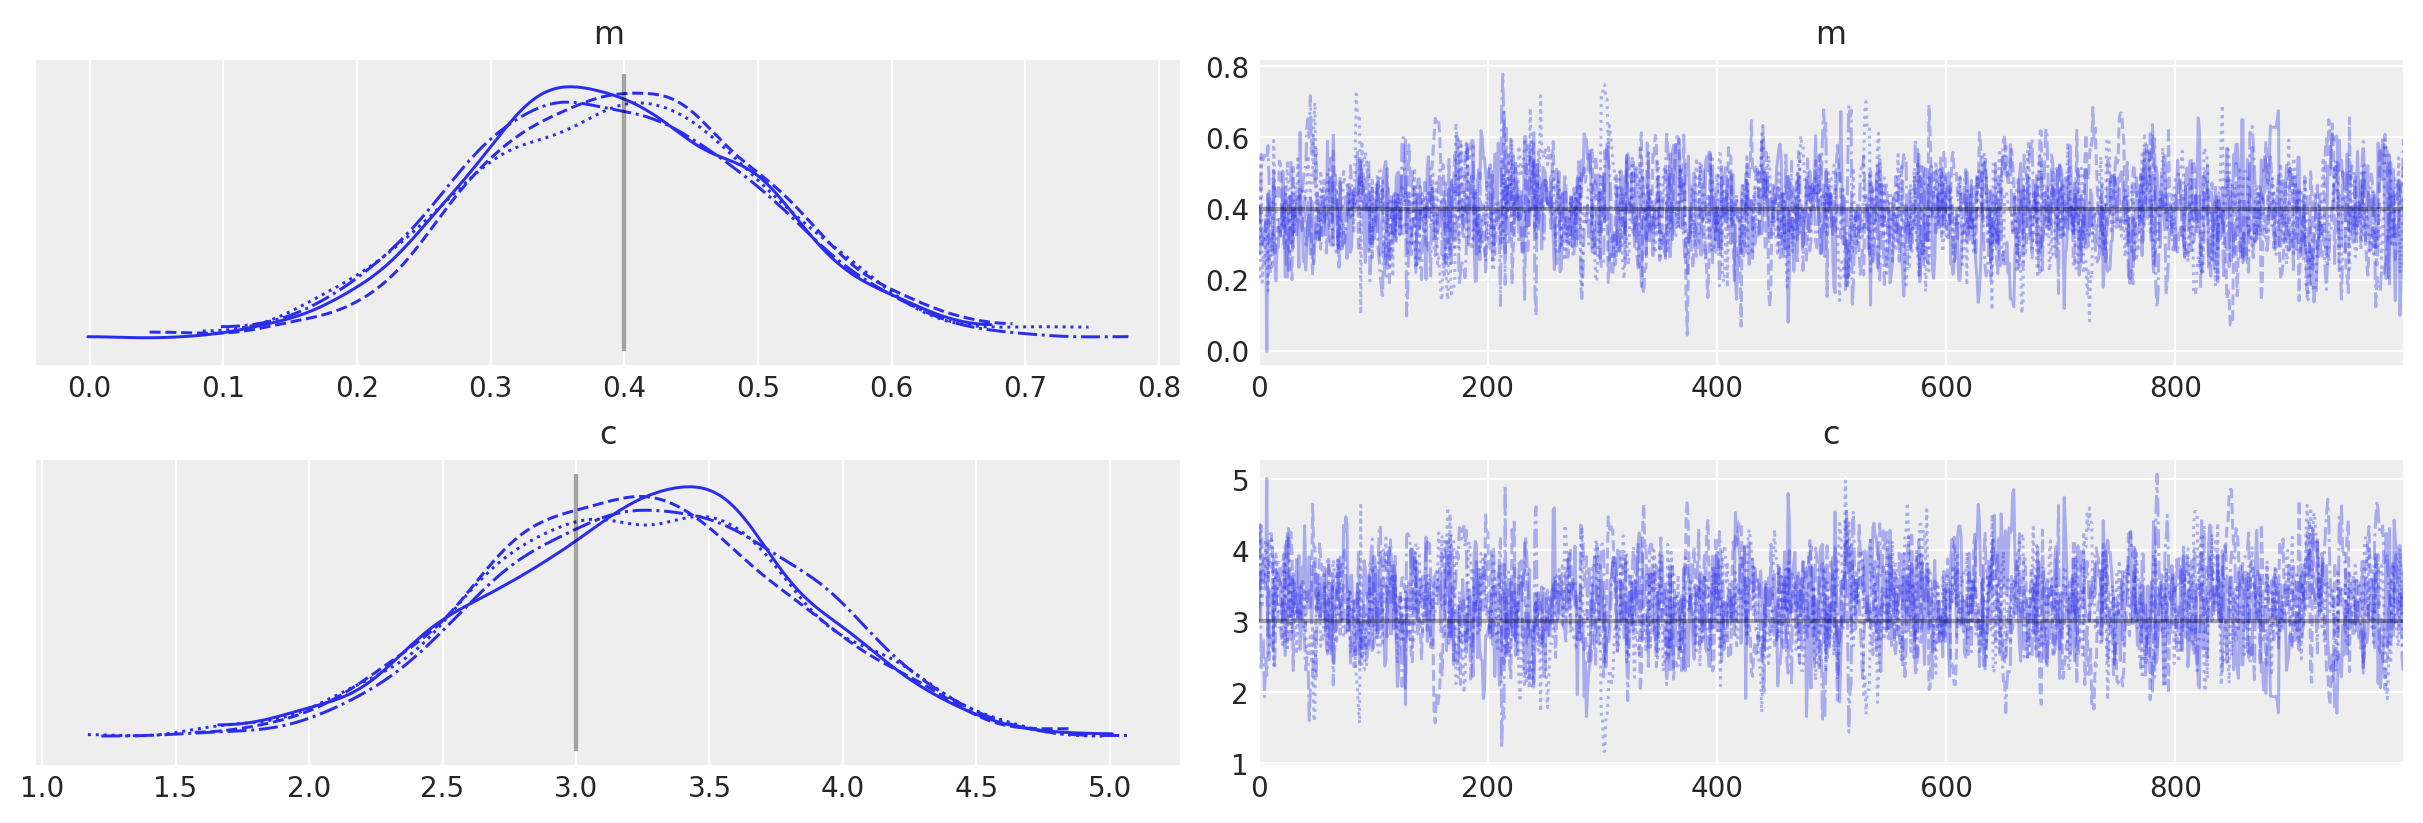

In [25]:
with grad_model:
    # Use custom number of draws to replace the HMC based defaults
    idata_grad = pm.sample()

# plot the traces
az.plot_trace(idata_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

## Comparison to equivalent PyMC distributions
Finally, just to check things actually worked as we might expect, let's do the same thing purely using PyMC distributions (because in this simple example we can!)

In [26]:
with pm.Model() as pure_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # use a Normal distribution
    likelihood = pm.Normal("likelihood", mu=(m * x + c), sigma=sigma, observed=data)

In [27]:
pure_model.compile_logp(vars=[likelihood], sum=False)(ip)

[array([-1.1063979 , -0.92587551, -1.34602737, -0.91918325, -1.72027674,
        -1.2816813 , -0.91895074, -1.02783982, -1.68422175, -1.45520871])]

In [28]:
pure_model.compile_dlogp()(ip)

array([41.52481384,  8.9342084 ])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


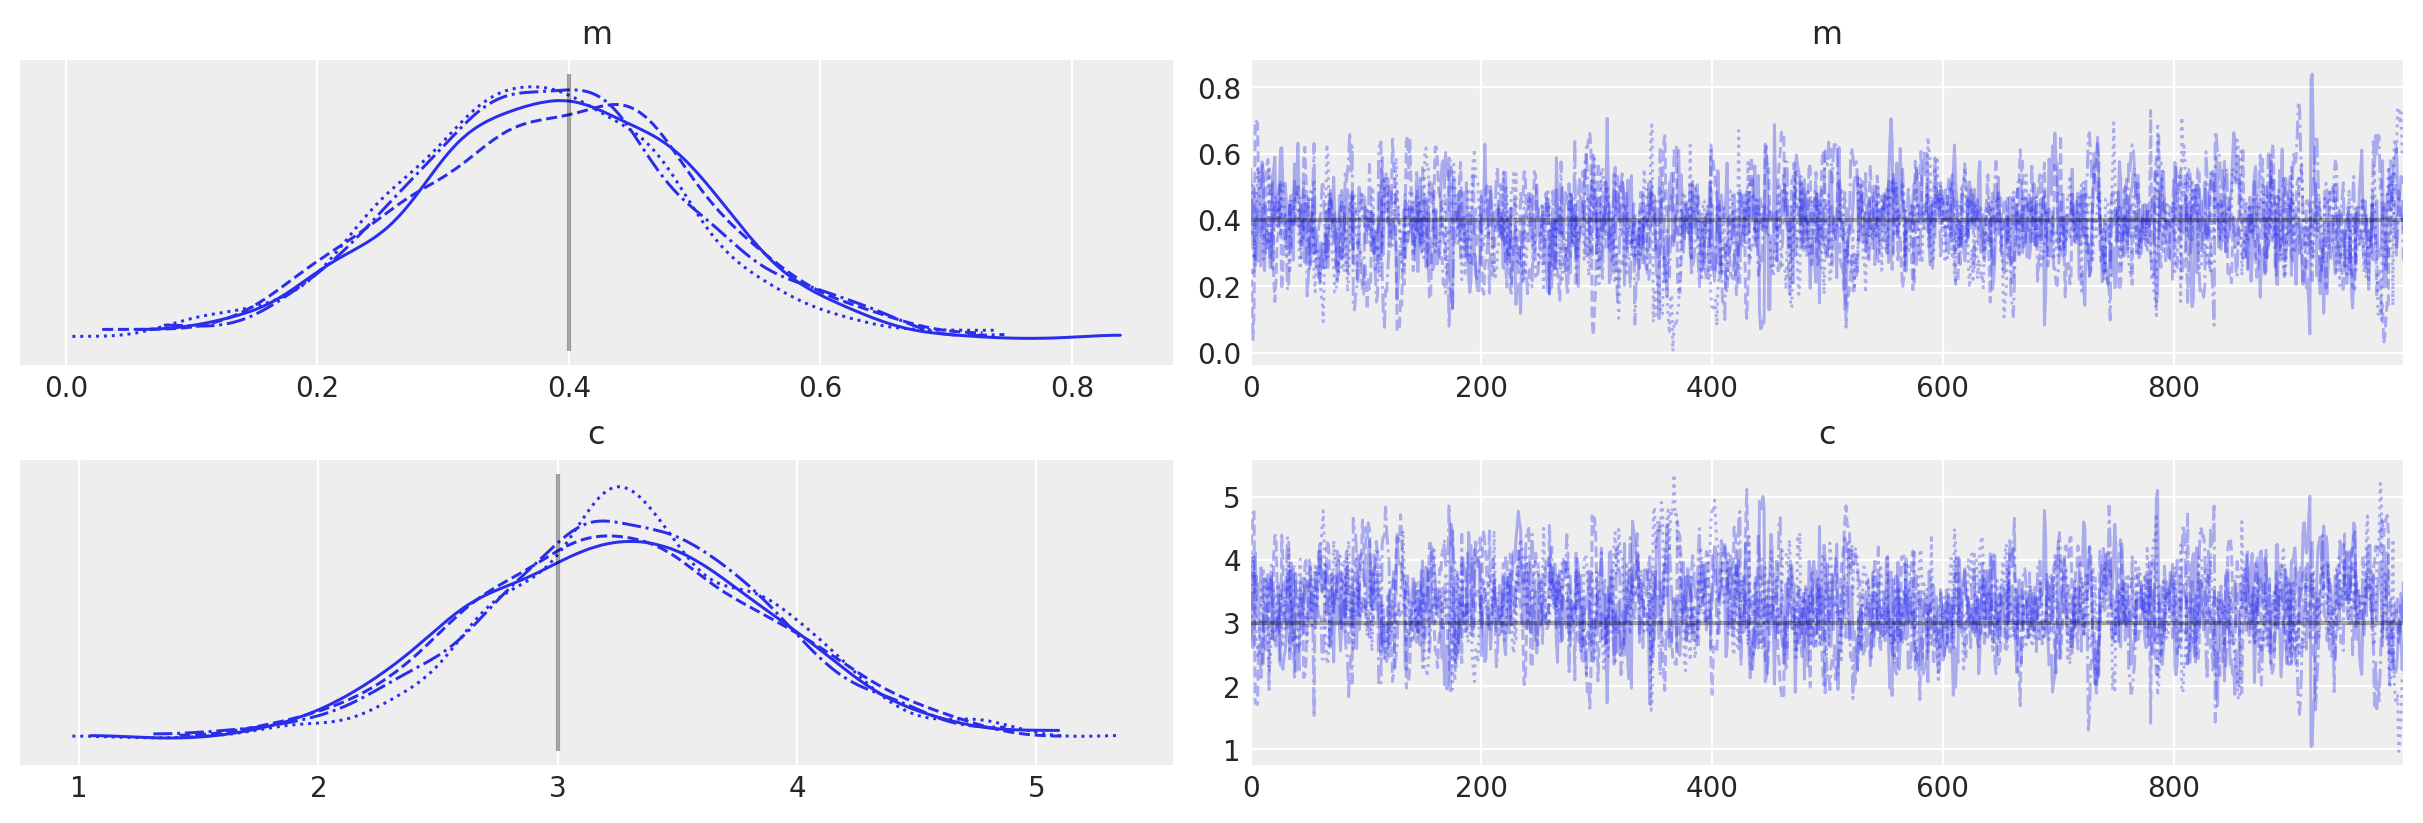

In [29]:
with pure_model:
    idata_pure = pm.sample()

# plot the traces
az.plot_trace(idata_pure, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

To check that they match let's plot all the examples together and also find the autocorrelation lengths.

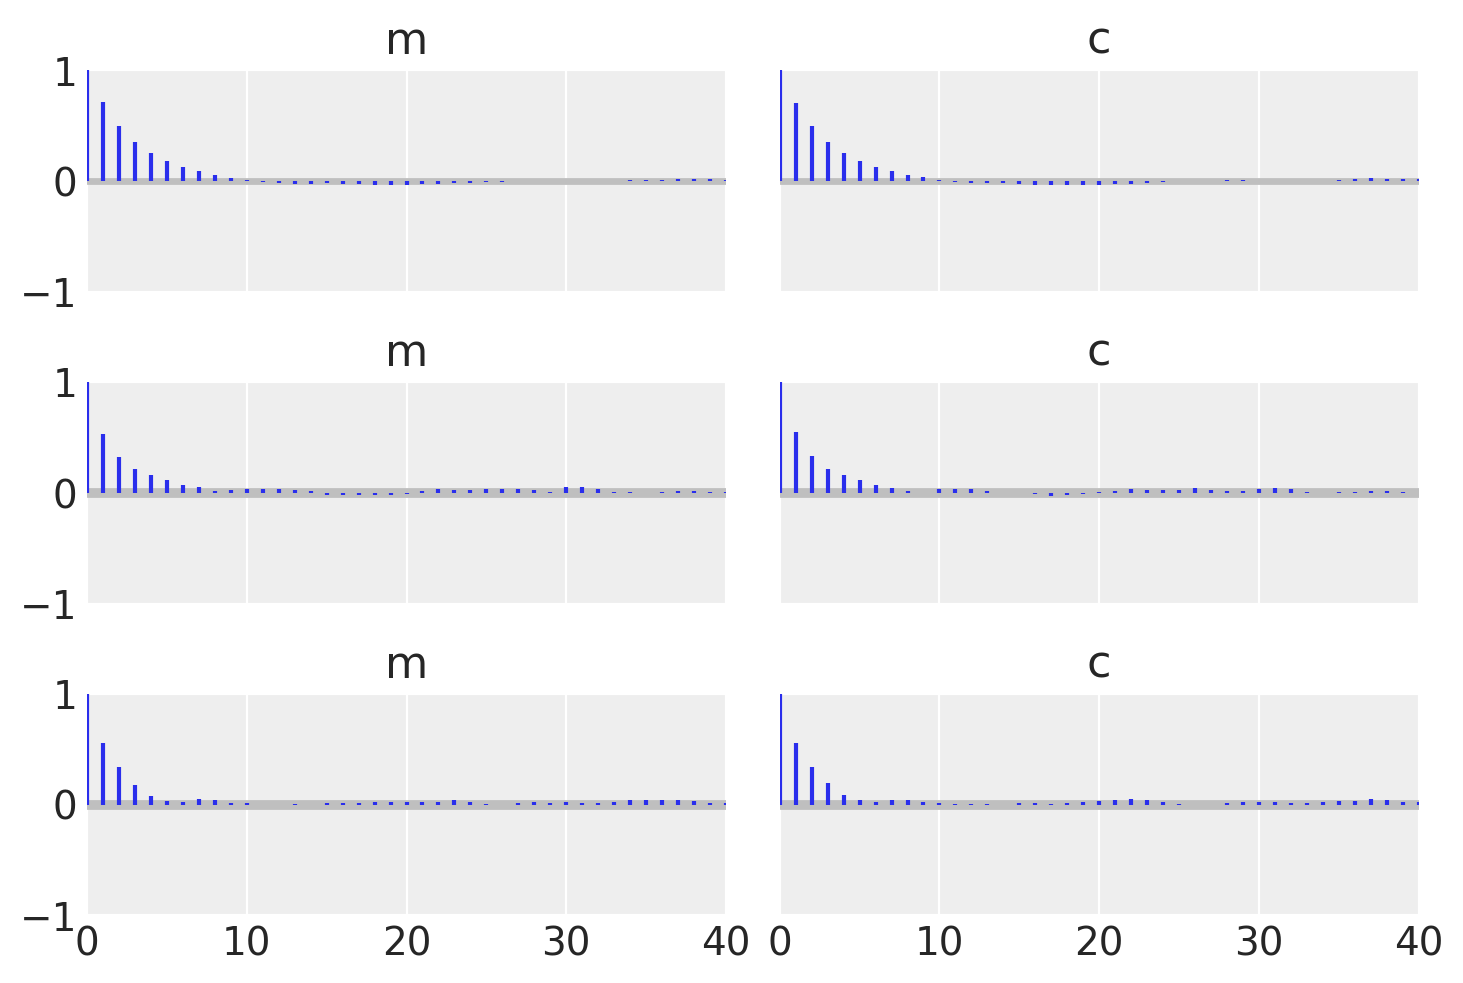

In [30]:
_, axes = plt.subplots(3, 2, sharex=True, sharey=True)
az.plot_autocorr(idata_no_grad, combined=True, ax=axes[0, :])
az.plot_autocorr(idata_grad, combined=True, ax=axes[1, :])
az.plot_autocorr(idata_pure, combined=True, ax=axes[2, :])
axes[2, 0].set_xlim(right=40);

/home/ricardo/miniconda3/envs/pymc-examples/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


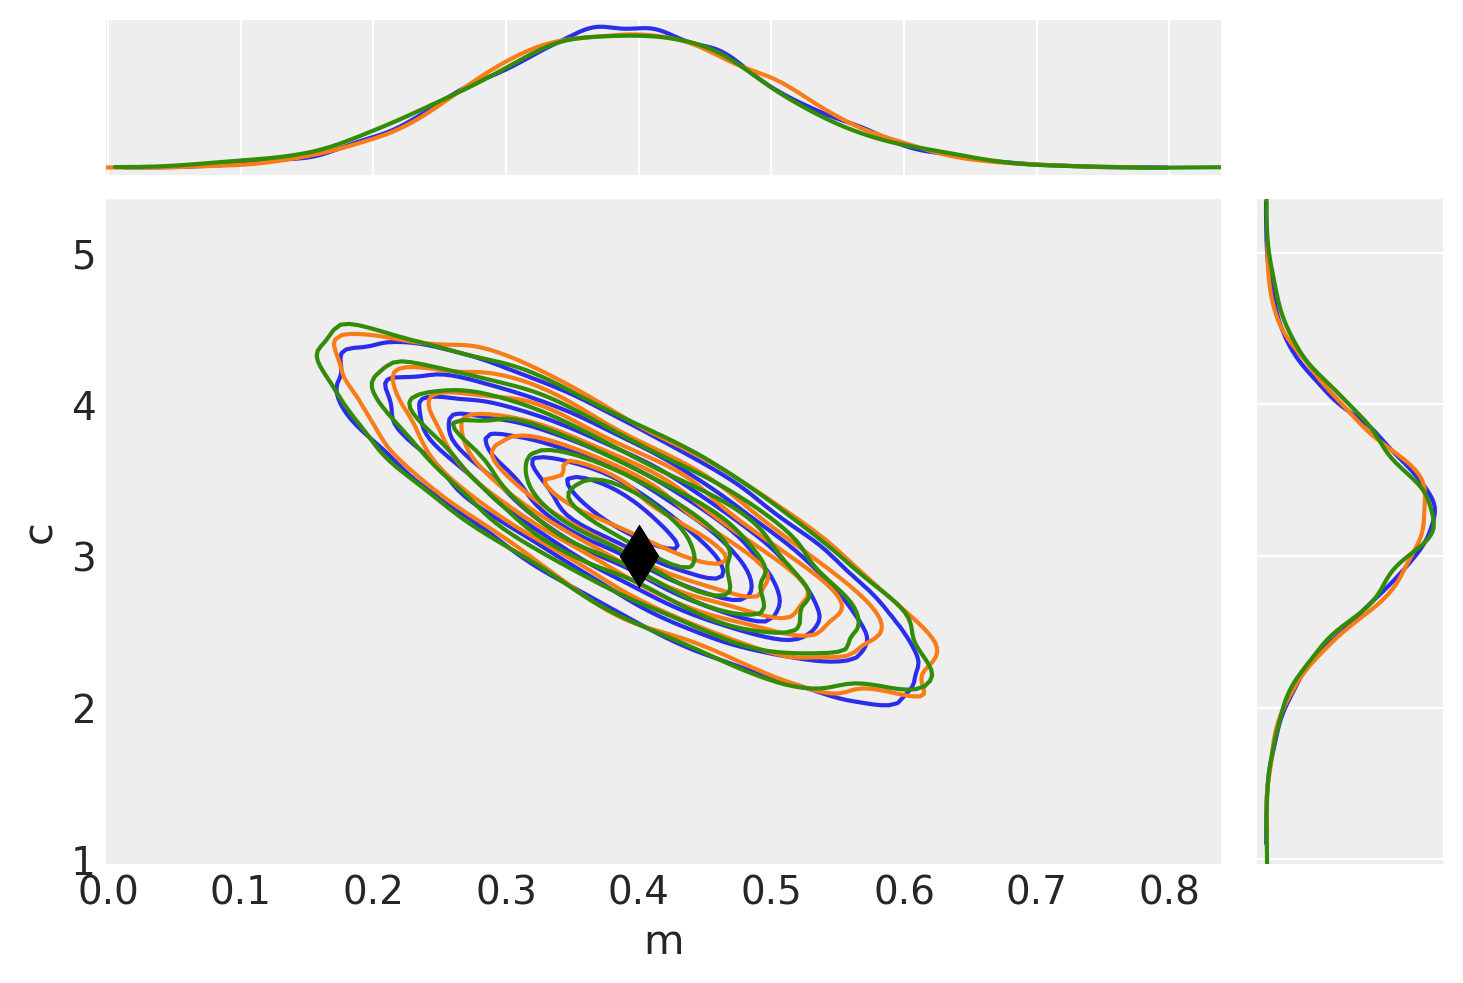

In [31]:
# Plot no grad result (blue)
pair_kwargs = dict(
    kind="kde",
    marginals=True,
    reference_values={"m": mtrue, "c": ctrue},
    kde_kwargs={"contourf_kwargs": {"alpha": 0}, "contour_kwargs": {"colors": "C0"}},
    reference_values_kwargs={"color": "k", "ms": 15, "marker": "d"},
    marginal_kwargs={"color": "C0"},
)
ax = az.plot_pair(idata_no_grad, **pair_kwargs)

# Plot nuts+blackbox fit (orange)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C1"
pair_kwargs["marginal_kwargs"]["color"] = "C1"
az.plot_pair(idata_grad, **pair_kwargs, ax=ax)

# Plot pure pymc+nuts fit (green)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C2"
pair_kwargs["marginal_kwargs"]["color"] = "C2"
az.plot_pair(idata_pure, **pair_kwargs, ax=ax);

## Using a Potential instead of CustomDist

In this section we show how a {func}`pymc.Potential` can be used to implement a black-box likelihood a bit more directly than when using a {class}`pymc.CustomDist`. 

The simpler interface comes at the cost of making other parts of the Bayesian workflow more cumbersome. For instance, as {func}`pymc.Potential` cannot be used for model comparison, as PyMC does not know whether a Potential term corresponds to a prior, a likelihood or even a mix of both. Potentials also have no forward sampling counterparts, which are needed for prior and posterior predictive sampling, while {class}`pymc.CustomDist` accepts `random` or `dist` functions for such occasions.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


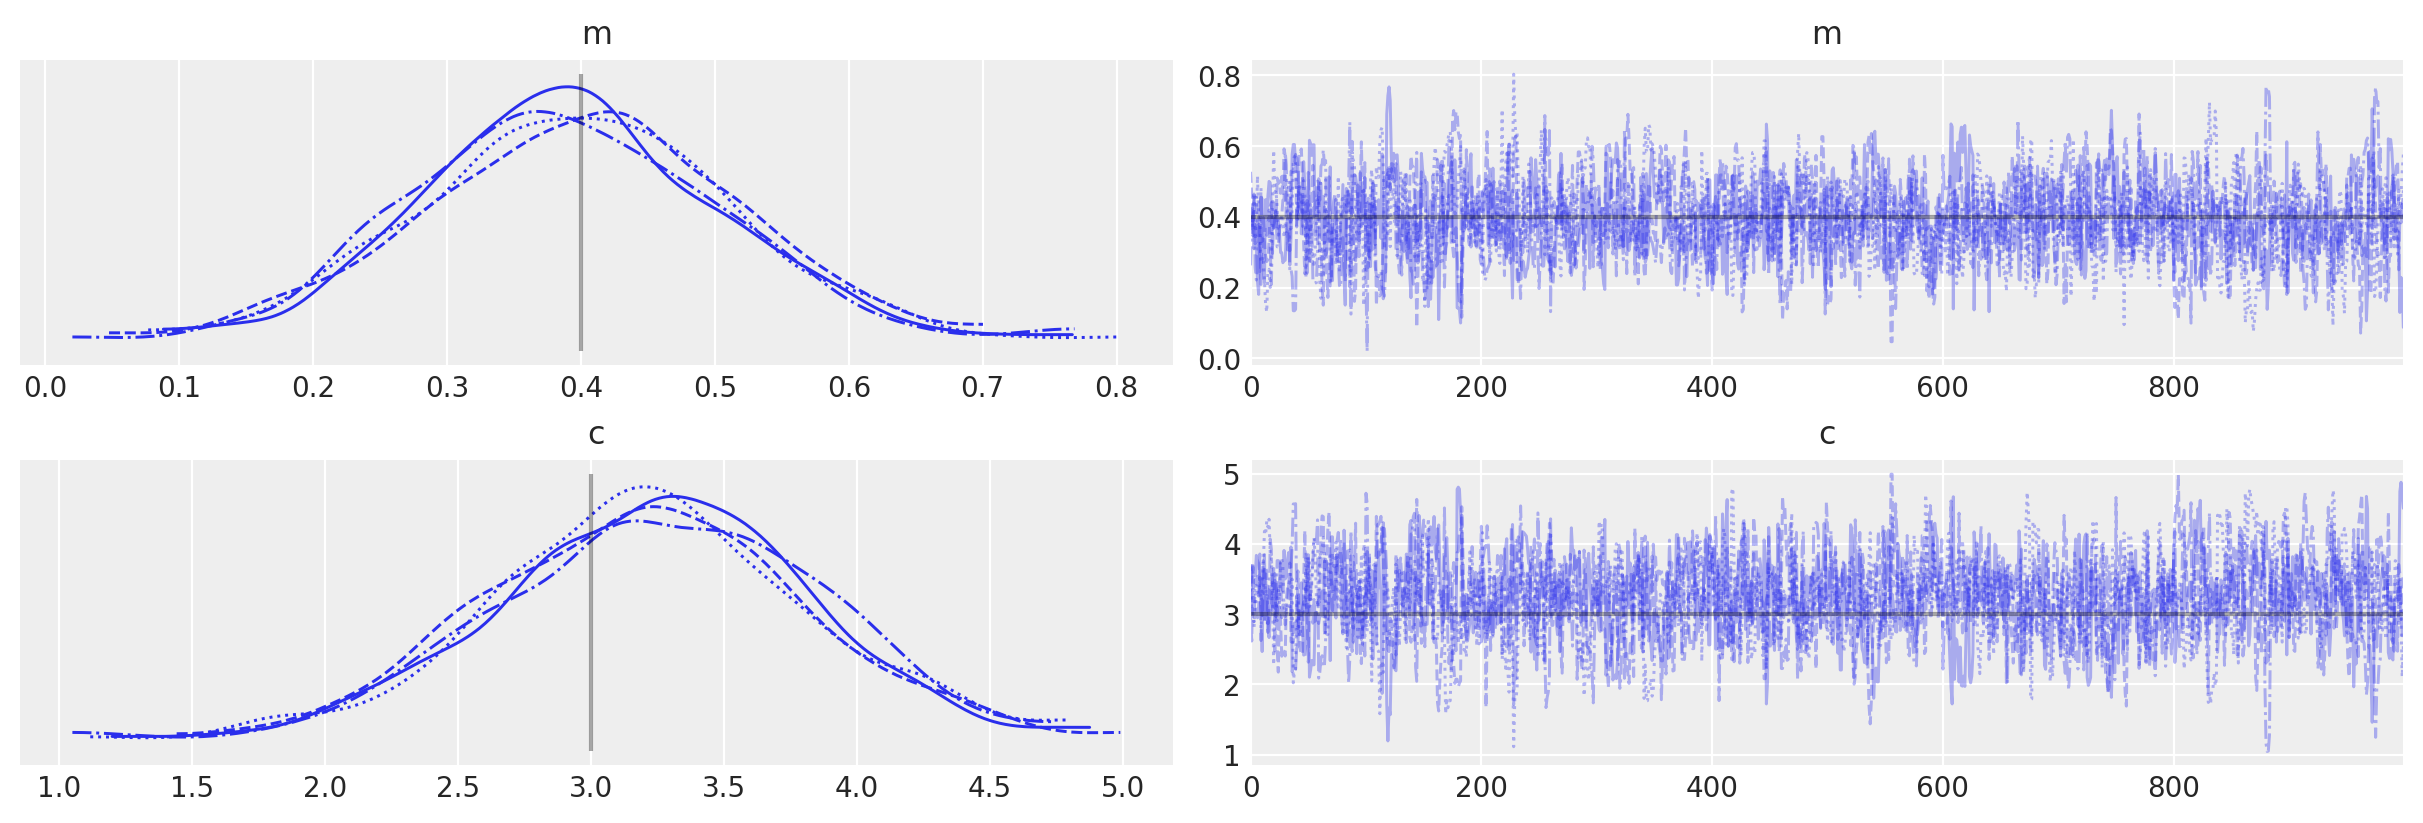

In [32]:
with pm.Model() as potential_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # use a Potential instead of a CustomDist
    pm.Potential("likelihood", loglikewithgrad_op(m, c, sigma, x, data))

    idata_potential = pm.sample()

# plot the traces
az.plot_trace(idata_potential, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

## Authors

* Adapted from [Jørgen Midtbø](https://github.com/jorgenem/)'s [example](https://discourse.pymc.io/t/connecting-pymc-to-external-code-help-with-understanding-pytensor-custom-ops/670) by Matt Pitkin both as a [blogpost](http://mattpitkin.github.io/samplers-demo/pages/pymc-blackbox-likelihood/) and as an example notebook to this gallery in August, 2018 ([pymc#3169](https://github.com/pymc-devs/pymc/pull/3169) and [pymc#3177](https://github.com/pymc-devs/pymc/pull/3177))
* Updated by [Oriol Abril](https://github.com/OriolAbril) on December 2021 to drop the Cython dependency from the original notebook and use numpy instead ([pymc-examples#28](https://github.com/pymc-devs/pymc-examples/pull/28))
* Re-executed by Oriol Abril with pymc 5.0.0 ([pymc-examples#496](https://github.com/pymc-devs/pymc-examples/pull/496))
* Updated by [Ricardo Vieira](https://github.com/ricardoV94/) on February 2024 to show an incremental implementation and debugging strategies, as well as to use CustomDist instead of Potential ([pymc-examples#631](https://github.com/pymc-devs/pymc-examples/pull/631))

## Watermark

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Wed Mar 13 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

xarray: 2024.1.1

arviz     : 0.17.0
pytensor  : 2.18.6
numpy     : 1.26.3
pymc      : 5.10.3
matplotlib: 3.8.2

Watermark: 2.4.3


:::{include} ../page_footer.md
:::